In [149]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import time

In [150]:
# Import
dataset = np.genfromtxt('train.csv',delimiter=',')
print(dataset[:5])

val_dataset = np.genfromtxt('Val_Classification.csv',delimiter=',')[1:]
print(val_dataset[:5])

[[-0.76736566 -1.37602208  0.        ]
 [-0.88588933 -1.95348755  0.        ]
 [-0.85173941 -1.91067527  0.        ]
 [-0.31965677  0.23438785  0.        ]
 [-2.23094524  0.9063236   0.        ]]
[[ 9.81524381  3.12505888]
 [ 8.47978778  4.02453599]
 [ 3.33619763  5.3264651 ]
 [ 3.35558965  5.18085611]
 [10.98610747  1.29918234]]


# KNN classifier from scratch

In [133]:
class KNN:
    '''Classifier via k-nearest neighbors voting.
        
    Example: 
    knn =KNN(4)  # initialize classifier of 4-NN
    knn.fit(Train_coor, Train_label) # fit the classifer with training data
    predicted = knn.predict(Test_coor, weighted = knn_weighted) # classifier predicts the label for testing data
    accuracy_measures.append(knn.accuracy_measure(Test_label, predicted)) # how similar the true label and predicted label are
    
    '''
    def __init__(self, k):
        self.k = k
    
    def fit(self, X, Y):
        '''Fit the k-nearest neighbors classifier from the training dataset.
        Parameters:
        X: {narray of shape (n_samples, n_features)} 
            Training data
        Y: {narray of shape (n_samples) }
            Label data
        
        Returns: The fitted k-nearest neighbors classifier
        '''
        self.X = X
        self.Y = Y.astype(int)
        return self
    
    def predict(self, X_test, weighted = "uniform"):
        '''Predict the class labels for the provided data.
        Parameters:
        X_test: {narray of shape (n_queries, n_features)}
                Test data
        weighted: "uniform" if k-nearest-neighbors have equal voting power, 
                  or "distance" if k-nearest-neighbors' voting power is 
                  disproportional to their distance from the test point, 
                  default = "uniform".
                  
        Returns: 
        {ndarray of shape (n_queries, n_classes)} 
        Class labels for each data sample.
        '''
        X = self.X
        Y = self.Y
        prediction = np.empty(len(X_test))
        
        for i in range(len(X_test)):
            new_data_point = X_test[i]
            # get K-neighbours
            distances = np.linalg.norm(X - new_data_point, axis=1)
            k = self.k
            nearest_neighbor_ids = distances.argsort()[:k]
            
            # Truth
            nearest_neighbor_rings = Y[nearest_neighbor_ids]
            
            if weighted == "uniform":
                # Majority Voting
                win = np.bincount(nearest_neighbor_rings).argmax()
            elif weighted == "distance":
                distance_inverse = 1/distances[nearest_neighbor_ids]
                norm = np.linalg.norm(distance_inverse)
                Weights = distance_inverse/norm
                # Distance Weighted Voting
                win = np.bincount(nearest_neighbor_rings, weights= Weights).argmax()
            prediction[i] = win
        return prediction
    
    def accuracy_measure(self, truth, predicted): #  https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/
        '''Return the accuracy on the given test data and labels.
        Parameters:
        truth: {narray of shape (n_queries, n_classes)}
                True label of test sample
        predicted: {narray of shape (n_queries, n_classes)}
                Predicted label of test sample
                  
        Returns: 
        {float} accuracy
        '''
        correct = 0
        for i in range(len(truth)):
            if truth[i] == predicted[i]:
                correct += 1
        return correct / float(len(truth))


# Cross validation using my classifier

In [134]:
def cross_validation_KNN(dataset, k, nfolds, knn_weighted = "uniform"):
    '''returns the average accuracy of KNN classifer under n-folds cross validation
    Parameters:
        dataset: {narray of shape (n_samples, n_features)}
                Training data, last position of sample's feature holds its' label
        k: {int} number of nearest neighbors used for KNN classifer
        nfolds: {int} number of equally sized folds to divide the dataset into.
        knn_weighted: "uniform" if k-nearest-neighbors have equal voting power, 
                  or "distance" if k-nearest-neighbors' voting power is 
                  disproportional to their distance from the test point, 
                  default = "uniform".
                  
        Returns: 
        {float} 
        average accuracy of k-NN classifer
    
    '''
    cross_validation = []
    accuracy_measures = []
    cuts = np.linspace(0, len(dataset), nfolds+1).astype(int)
    
    for i in range(1,len(cuts)):
        start,end = cuts[i-1], cuts[i]
        test = dataset[start:end,:-1]
        test_label = dataset[start:end,-1]
        train = np.vstack([dataset[0:start], dataset[end:]])
        cross_validation.append((train, test, test_label))
    
    for train, test, test_label in cross_validation:
        knn =KNN(k)
        knn.fit(train[:,:-1], train[:,-1])
        predicted = knn.predict(test, weighted = knn_weighted)
        accuracy_measures.append(knn.accuracy_measure(test_label, predicted))
    average_accuracy = sum(accuracy_measures) / len(accuracy_measures)
    return average_accuracy

    
nfolds = 10
for k in range(1,10):
    uniform = np.round(cross_validation_KNN(dataset, k, nfolds, knn_weighted = "uniform"), 3)
    distance = np.round(cross_validation_KNN(dataset, k, nfolds, knn_weighted = "distance"), 3)
    print("k = ", k, ", by uniform: ", uniform, ", by distance: ", distance)

k =  1 , by uniform:  0.906 , by distance:  0.906
k =  2 , by uniform:  0.915 , by distance:  0.906
k =  3 , by uniform:  0.925 , by distance:  0.922
k =  4 , by uniform:  0.928 , by distance:  0.922
k =  5 , by uniform:  0.92 , by distance:  0.923
k =  6 , by uniform:  0.923 , by distance:  0.917
k =  7 , by uniform:  0.916 , by distance:  0.92
k =  8 , by uniform:  0.923 , by distance:  0.917
k =  9 , by uniform:  0.917 , by distance:  0.917


# Cross validation using sklearn KNeighborsClassifier

In [135]:
from sklearn.neighbors import KNeighborsClassifier
def cross_validation_sklearn(dataset, k, nfolds, knn_weighted = "uniform"):
    '''returns the average accuracy of sklearn KNeighborsClassifier classifer under n-folds cross validation
    Parameters:
        dataset: {narray of shape (n_samples, n_features)}
                Training data, last position of sample's feature holds its' label
        k: {int} number of nearest neighbors used for sklearn KNeighborsClassifier classifer
        nfolds: {int} number of equally sized folds to divide the dataset into.
        knn_weighted: "uniform" if k-nearest-neighbors have equal voting power, 
                  or "distance" if k-nearest-neighbors' voting power is 
                  disproportional to their distance from the test point, 
                  default = "uniform".
                  
        Returns: 
        {float} 
        average accuracy of sklearn KNeighborsClassifier classifer under input k condition
    
    '''
    cross_validation = []
    accuracy_measures = []
    cuts = np.linspace(0, len(dataset), nfolds+1).astype(int)
    
    for i in range(1,len(cuts)):
        start,end = cuts[i-1], cuts[i]
        test = dataset[start:end,:-1]
        test_label = dataset[start:end,-1]
        train = np.vstack([dataset[0:start], dataset[end:]])
        cross_validation.append((train, test, test_label))
    
    for train, test, test_label in cross_validation:
        neigh = KNeighborsClassifier(n_neighbors=k, weights=knn_weighted)
        neigh.fit(train[:,:-1], train[:,-1])
        accuracy_measures.append(neigh.score(test, test_label))
        
    average_accuracy = sum(accuracy_measures) / len(accuracy_measures)
    return average_accuracy

nfolds = 10
for k in range(1,10):
    average_accuracy = cross_validation_sklearn(dataset, k, nfolds, knn_weighted = "distance")
    print("k = ", k, ", average accuracy = ", average_accuracy)

k =  1 , average accuracy =  0.906076388888889
k =  2 , average accuracy =  0.906076388888889
k =  3 , average accuracy =  0.9217261904761905
k =  4 , average accuracy =  0.9217261904761905
k =  5 , average accuracy =  0.9233134920634921
k =  6 , average accuracy =  0.9170634920634921
k =  7 , average accuracy =  0.9201884920634921
k =  8 , average accuracy =  0.9170634920634921
k =  9 , average accuracy =  0.9170634920634921


# Finding outliers

In [136]:
def find_outliers(dataset,k,knn_weighted = "uniform"):
    '''
    returns a list of indices of outliers in dataset, using KNN classifier with same parameters k and knn_weighted
  
    dataset: {narray of shape (n_samples, n_features)}
            Training data, last position of sample's feature holds its' label
    k: {int} number of nearest neighbors used for sklearn KNeighborsClassifier classifer
    knn_weighted: "uniform" if k-nearest-neighbors have equal voting power, 
              or "distance" if k-nearest-neighbors' voting power is 
              disproportional to their distance from the test point, 
              default = "uniform".

    Returns: 
    {list of lenght n_sample} 
    a list of indices of outliers in dataset

    '''
    adjusted = [n for n in range(len(dataset))]
    outliers = []
    i = 0
    while i < len(adjusted):
        # take xi out from adjusted temporarily      
        train_id = adjusted[:i]
        train_id.extend(adjusted[i+1:])
        xi = adjusted[i]
        
        train = dataset[train_id]
        x = dataset[xi]
        test = x[:-1].reshape((1,2))
        test_label = x[-1]
    
        # classify xi using my classifier
        knn =KNN(k)
        knn.fit(train[:,:-1], train[:,-1])
        predicted = knn.predict(test, weighted = knn_weighted)
        

        # classify xi using sklearn
        # neigh = KNeighborsClassifier(n_neighbors=k, weights=knn_weighted)
        # neigh.fit(train[:,:-1], train[:,-1])
        # predicted = neigh.predict(test)
        
        if test_label == predicted[0]:
            i += 1
            
        else:
            adjusted = train_id
            outliers.append(xi)
    return outliers



In [137]:
 for k in range(1,10):
    outliers = find_outliers(dataset, k, knn_weighted = "uniform")
    print(k, "-NN classifier found ", len(outliers), "outliers")


1 -NN classifier found  38 outliers
2 -NN classifier found  34 outliers
3 -NN classifier found  32 outliers
4 -NN classifier found  33 outliers
5 -NN classifier found  33 outliers
6 -NN classifier found  32 outliers
7 -NN classifier found  34 outliers
8 -NN classifier found  34 outliers
9 -NN classifier found  34 outliers


# Finding prototypes and absorbed points

In [138]:
def find_abs_pro(dataset,knn_weighted = "uniform"):
    '''
    returns indices of prototypes and indices of absorbed points from input dataset,
    using 1-nn KNN classifier with same parameter knn_weighted
    
    dataset: {narray of shape (n_samples, n_features)}
            Training data, last position of sample's feature holds its' label
   
    knn_weighted: "uniform" if k-nearest-neighbors have equal voting power, 
              or "distance" if k-nearest-neighbors' voting power is 
              disproportional to their distance from the test point, 
              default = "uniform".

    Returns: 
    {tuple of 2 lists} 
    a list of absorbed points' indices, 
    a list of prototype's indices

    '''
    abs = [n for n in range(len(dataset))]
    index = np.random.randint(len(abs))
    pro = [index]
    abs.remove(index)
    U = abs.copy()
    while len(U) != 0:
        ui = np.random.randint(0,len(U))
        xi = U[ui]
    
        # classify x with prototype as training data
        train = dataset[pro]
        test = dataset[xi][:-1].reshape((1,2))
        test_label = dataset[xi][-1]
        knn =KNN(1)
        knn.fit(train[:,:-1], train[:,-1])
        predicted = knn.predict(test, weighted =knn_weighted )
    
        if test_label == predicted[0]:
            U.remove(xi)
        else:
            pro.append(xi)
            abs.remove(xi)
    return abs, pro


In [139]:
# Get new dataset, get rid of outliers
outliers = find_outliers(dataset, 3, knn_weighted = "uniform")
set_difference = set(range(len(dataset))) - set(outliers)
dataset_id = list(set_difference)
new_dataset = dataset[dataset_id]

# Separate new dataset into absorbed- and prototype points
np.random.seed(seed = 200)
abs, pro = find_abs_pro(new_dataset,knn_weighted = "uniform")
Abs_set = new_dataset[abs]
Pro_set = new_dataset[pro] 

print("Original len(dataset): ", len(dataset))
print("Outliers: ", len(dataset)- len(new_dataset), " ( ",(len(dataset)- len(new_dataset))/len(dataset)*100, "%")
print("Absorbed points found:  ", len(abs))
print("24 Prototypes found, seed = 0 ")
print("16 Prototypes found, seed = 100 ")
print("19 Prototypes found, seed = 200 ")

Original len(dataset):  637
Outliers:  32  (  5.023547880690738 %
Absorbed points found:   586
24 Prototypes found, seed = 0 
16 Prototypes found, seed = 100 
19 Prototypes found, seed = 200 


In [145]:

np.random.seed(seed = 10)
pro = find_abs_pro(new_dataset,knn_weighted = "uniform")[1]
prev = new_dataset[pro] 
    
for seeds in range(10):
    np.random.seed(seed = seeds)
    pro = find_abs_pro(new_dataset,knn_weighted = "uniform")[1]
    Pro_set = new_dataset[pro] 
    inter = np.intersect1d(Pro_set,prev)
    prev = Pro_set
    print(len(inter))

10
14
12
22
12
10
12
14
12
14


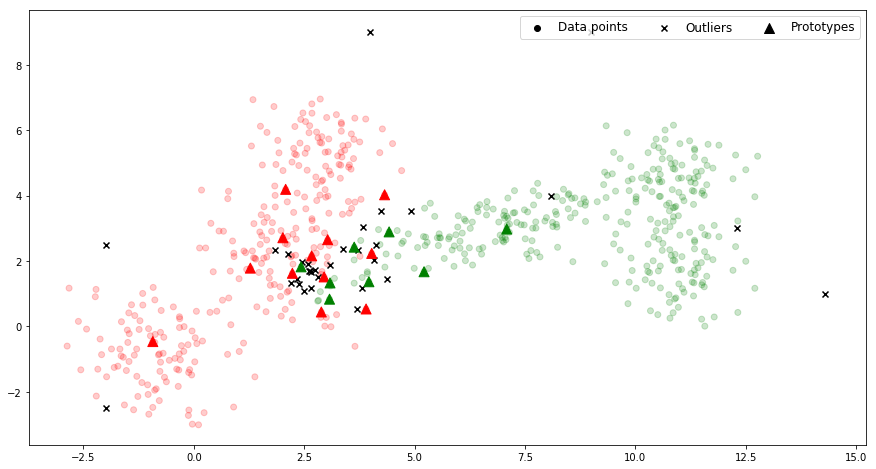

In [146]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams["figure.figsize"] = (15,8)
color= ['red' if l == 0 else 'green' for l in new_dataset[:,2]]
color2= ['red' if l == 0 else 'green' for l in Pro_set[:,2]]
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii
O = dataset[outliers]
normal = plt.scatter(new_dataset[:,0], new_dataset[:,1], alpha=0.2, c = color,label="data points")
O = plt.scatter(O[:,0], O[:,1], c='black',marker = "x")
P = plt.scatter(Pro_set[:,0], Pro_set[:,1], c= color2, marker = "^", s=100)
leg = plt.legend((normal,O,P),
           ('Data points', 'Outliers','Prototypes'),
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           fontsize=12)
for marker in leg.legendHandles:
    marker.set_color('black')
    marker.set_alpha(1)
plt.show()

# Classify Validation dataset using Prototype

In [147]:
# Using validation data as test set
test = val_dataset
k=3

# Classify test set by Prototypes
#print("- with knn classifier")
#t0 = time.perf_counter()
knn = KNN(k)
knn.fit(Pro_set[:,:-1], Pro_set[:,-1])
predicted = knn.predict(test, weighted = "uniform")
#t1 = time.perf_counter()
knn2 = KNN(k)
knn2.fit(dataset[:,:-1], dataset[:,-1])
predicted_original = knn.predict(test, weighted = "uniform")
#t2 = time.perf_counter()
print(np.all(predicted == predicted_original))


#print("- with sklearn classifier")   
neigh = KNeighborsClassifier(n_neighbors=k, weights="uniform")
neigh.fit(Pro_set[:,:-1], Pro_set[:,-1])
predicted_sklearn = neigh.predict(test)
#print(predicted_sklearn)

#--------------RESULTs---------------
# Label predicted by my classifer KNN
#print(predicted)
# Label predicted by sklearn classifer
#print(predicted_sklearn)
# check if they predict the same result
print(np.all(predicted == predicted_sklearn))

True
True


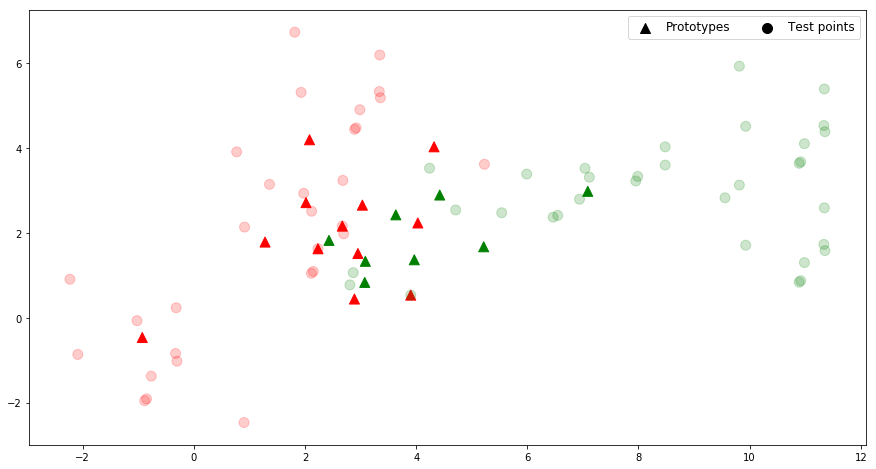

In [148]:
plt.rcParams["figure.figsize"] = (15,8)
color= ['red' if l == 0 else 'green' for l in new_dataset[:,2]]
color2= ['red' if l == 0 else 'green' for l in Pro_set[:,2]]
color3= ['red' if l == 0 else 'green' for l in predicted]
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii
O = dataset[outliers]
#normal = plt.scatter(new_dataset[:,0], new_dataset[:,1], alpha=0.2, c = color,label="data points")
#O = plt.scatter(O[:,0], O[:,1], c='black',marker = "x")
P = plt.scatter(Pro_set[:,0], Pro_set[:,1], c= color2, marker = "^", s=100)
Predicted =plt.scatter(test[:,0], test[:,1],alpha=0.2, c= color3, marker = "o", s=100) 
leg =plt.legend((P,Predicted),
           ('Prototypes', 'Test points'),
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           fontsize=12)
for marker in leg.legendHandles:
    marker.set_color('black')
    marker.set_alpha(1)
plt.show()